In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from mpl_toolkits import mplot3d
import matplotlib.gridspec as gridspec
from scipy import stats
import lightgbm as lgbm
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import r2_score

pd.set_option('max_columns',100)

In [2]:
pd.set_option('display.max_rows', None)

### Import and Clean Data

In [3]:
# Import CSV data
vehicles_df = pd.read_csv('carsdataset.csv', encoding='ISO-8859-1')

In [4]:
vehicles_df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [5]:
vehicles_df.shape

(11914, 16)

In [6]:
# Find types of dataframe columns
vehicles_df.dtypes

Make                  object
Model                 object
Year                   int64
Engine Fuel Type      object
Engine HP            float64
Engine Cylinders     float64
Transmission Type     object
Driven_Wheels         object
Number of Doors      float64
Market Category       object
Vehicle Size          object
Vehicle Style         object
highway MPG            int64
city mpg               int64
Popularity             int64
MSRP                   int64
dtype: object

In [7]:
# Find percentage of rows by column that are empty
vehicles_df.isnull().mean()

Make                 0.000000
Model                0.000000
Year                 0.000000
Engine Fuel Type     0.000252
Engine HP            0.005792
Engine Cylinders     0.002518
Transmission Type    0.000000
Driven_Wheels        0.000000
Number of Doors      0.000504
Market Category      0.314084
Vehicle Size         0.000000
Vehicle Style        0.000000
highway MPG          0.000000
city mpg             0.000000
Popularity           0.000000
MSRP                 0.000000
dtype: float64

In [8]:
# Drop columns that are greater than 10% empty
new_vehicles_df = vehicles_df.loc[:, vehicles_df.isnull().mean() < 0.1]
new_vehicles_df.isnull().mean()
new_vehicles_df.shape

(11914, 15)

### Preparing the Data for Regression (finding outliers)

In [9]:
# Drop outlier rows with 0 or negative price
filtered_new_df = new_vehicles_df.loc[(new_vehicles_df['MSRP'] > 0)]
filtered_new_df.shape

(11914, 15)

Text(0.5,0,'Continuous Variable')

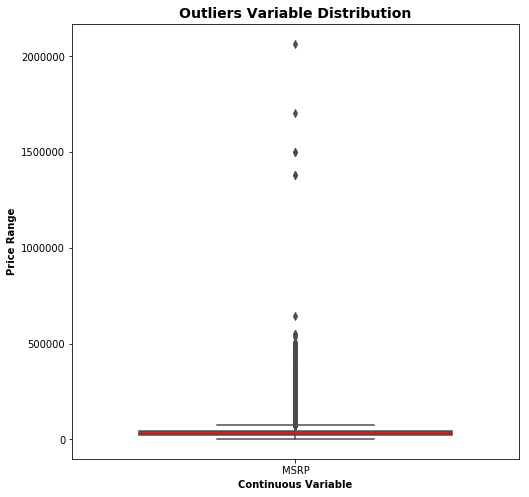

In [10]:
# Find other outliers in price
outliers = ['MSRP']
plt.rcParams['figure.figsize'] = [8,8]
sns.boxplot(data=filtered_new_df[outliers], orient="v", palette="Set1" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Price Range", fontweight = 'bold')
plt.xlabel("Continuous Variable", fontweight = 'bold')

In [11]:
# Drop the few cars that are very overpriced
final_df = filtered_new_df.loc[(filtered_new_df['MSRP'] <= 500000)]

Text(0.5,0,'Continuous Variable')

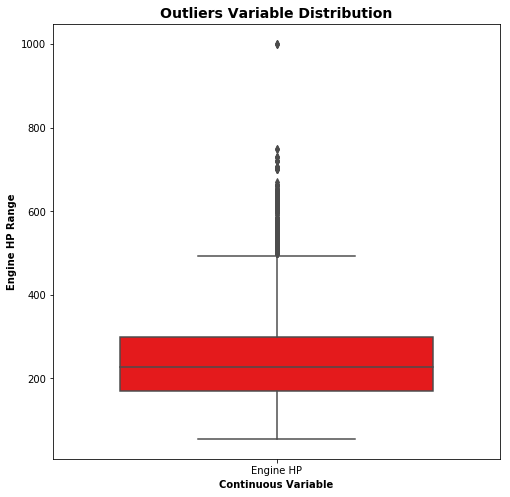

In [12]:
# Find outliers in Engine HP
outliers = ['Engine HP']
plt.rcParams['figure.figsize'] = [8,8]
sns.boxplot(data=filtered_new_df[outliers], orient="v", palette="Set1" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Engine HP Range", fontweight = 'bold')
plt.xlabel("Continuous Variable", fontweight = 'bold')

In [13]:
# Filter for cars with HP less than 800
final_df = final_df.loc[(filtered_new_df['Engine HP'] <= 800)]
final_df.shape

(11834, 15)

In [14]:
# Finally, drop any rows with null value
final_df.dropna(how='any', inplace=True)
final_df.head()
final_df.shape

(11801, 15)

### Graph Car Make Counts and Average Price

In [15]:
# Group counts by car make
make_count = final_df.groupby('Make').count()['MSRP']
make_count_df = pd.DataFrame(make_count).reset_index()
make_count_df.columns = ['Make','Count']

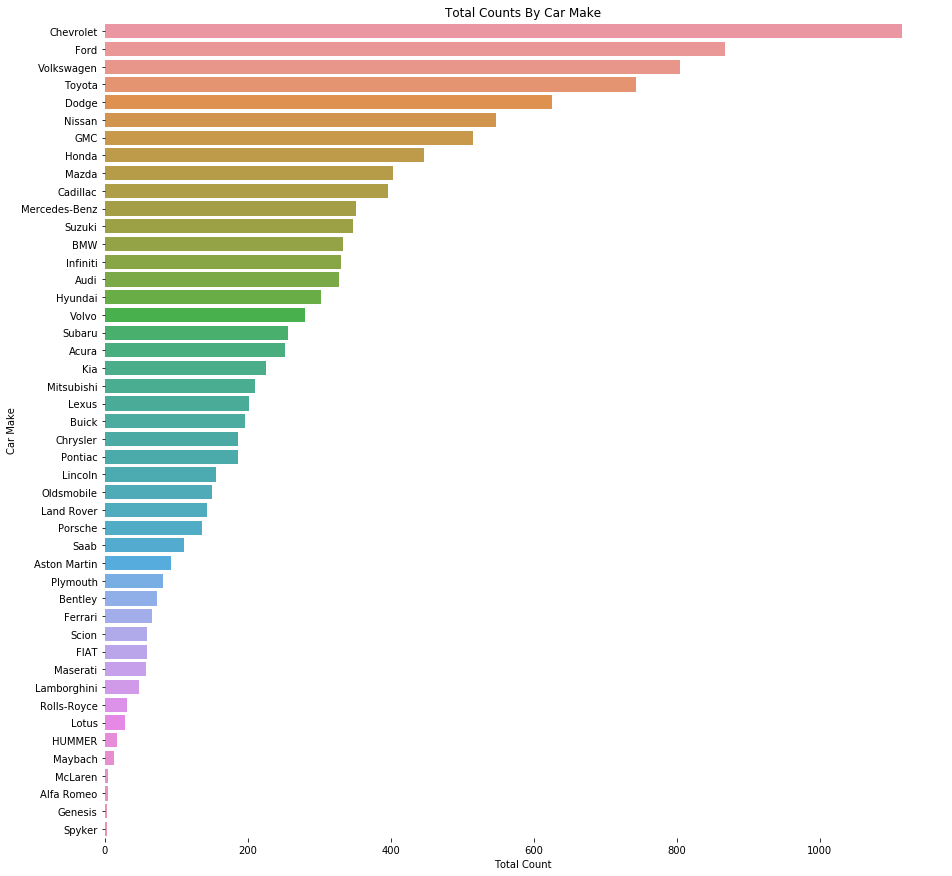

In [16]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Plot the total counts
sns.barplot(x="Count", y="Make", data=make_count_df.sort_values('Count', ascending=False).reset_index(drop=True),
            label="Total Count")

# Add title, legend and informative axis label
ax.set(title="Total Counts By Car Make",
       ylabel="Car Make",
       xlabel="Total Count")
sns.despine(left=True, bottom=True)

In [17]:
# Avg price per car make
make_avg_price = final_df.groupby('Make').mean()['MSRP']
make_avg_price_df = pd.DataFrame(make_avg_price).reset_index()
make_avg_price_df.columns = ['Make','Avg Price']

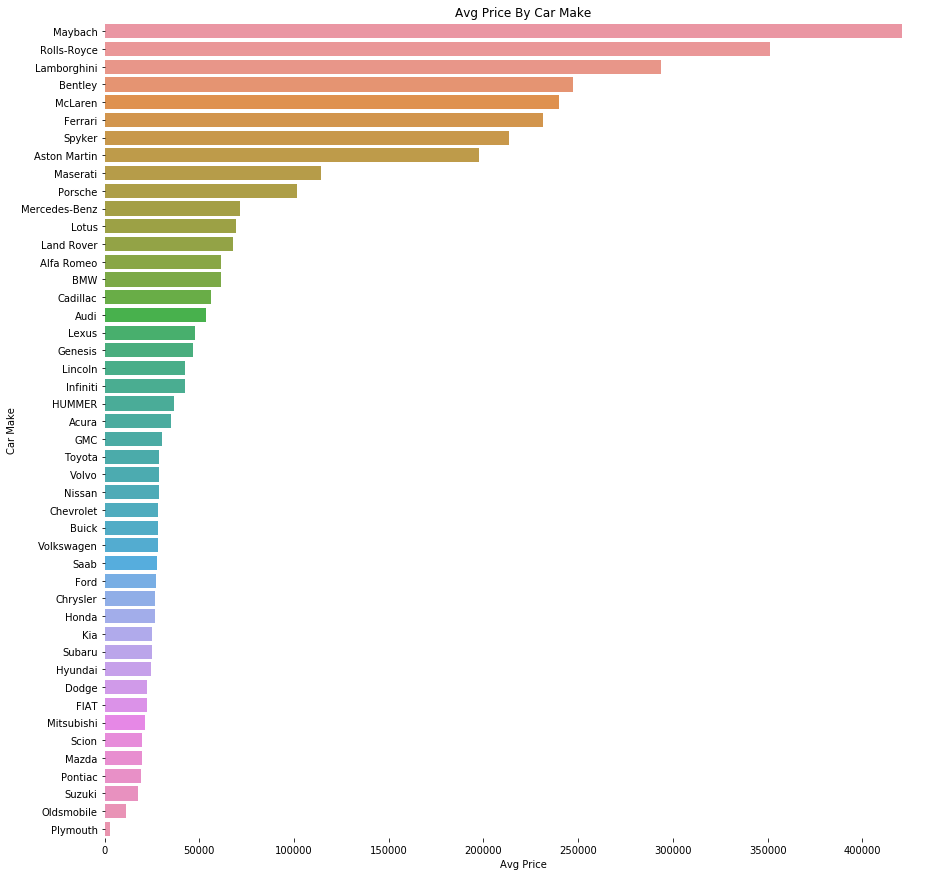

In [18]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Plot the total counts
sns.barplot(x="Avg Price", y="Make", data=make_avg_price_df.sort_values('Avg Price', ascending=False).reset_index(drop=True),
            label="Avg Price")

# Add title, legend and informative axis label
ax.set(title="Avg Price By Car Make",
       ylabel="Car Make",
       xlabel="Avg Price")
sns.despine(left=True, bottom=True)

### Correlation Matrix

In [19]:
# Create new dataframe for correlation
correlation_df = final_df

In [20]:
# Convert categorical data into numerical data for regression 
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_columns = []
features = correlation_df.columns.values.tolist()
for col in features:
    if correlation_df[col].dtype in numerics: continue
    categorical_columns.append(col)
# Encoding categorical features
for col in categorical_columns:
    if col in correlation_df.columns:
        le = LabelEncoder()
        le.fit(list(correlation_df[col].astype(str).values))
        correlation_df[col] = le.transform(list(correlation_df[col].astype(str).values))

In [21]:
# View new dataframe
correlation_df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,4,1,2011,7,335.0,6.0,3,3,2.0,0,8,26,19,3916,46135
1,4,0,2011,7,300.0,6.0,3,3,2.0,0,6,28,19,3916,40650
2,4,0,2011,7,300.0,6.0,3,3,2.0,0,8,28,20,3916,36350
3,4,0,2011,7,230.0,6.0,3,3,2.0,0,8,28,18,3916,29450
4,4,0,2011,7,230.0,6.0,3,3,2.0,0,6,28,18,3916,34500


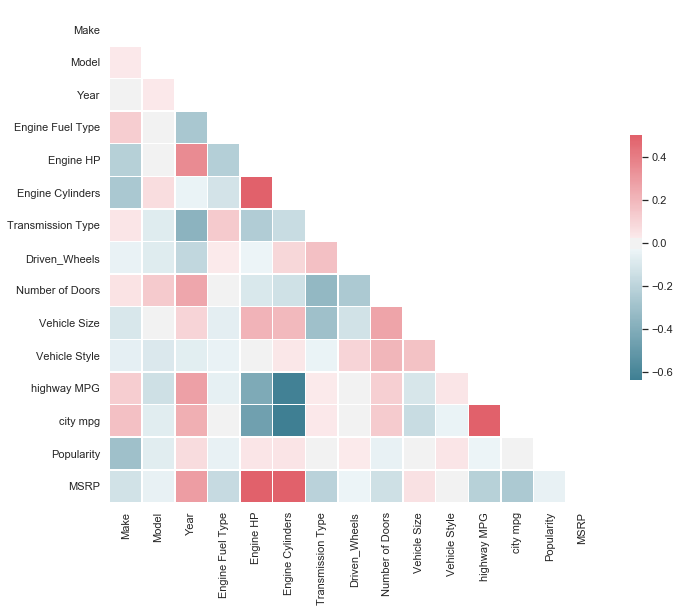

In [22]:
# Graphing the correlation matrix
sns.set(style="white")

corr = correlation_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [23]:
# LINEAR REGRESSION

In [24]:
linr_df_dummy = pd.get_dummies(test_data_df,drop_first=True)

NameError: name 'test_data_df' is not defined

In [ ]:
linr_df = linr_df_dummy

In [ ]:
target = 'MSRP'

In [ ]:
X = linr_df.drop(target, axis=1)
y = linr_df['MSRP'].values.reshape(-1, 1)
print(X.shape, y.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [ ]:
model = LinearRegression()

In [ ]:
model.fit(X_train, y_train)
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

In [ ]:
plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="blue", label="Training Data")
plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y.min(), xmax=y.max())
plt.title("Residual Plot")

### Random Forest Regression

In [ ]:
# Create new dataframe for regression
test_data_df = final_df

In [ ]:
# Convert categorical data into numerical data for regression 
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_columns = []
features = test_data_df.columns.values.tolist()
for col in features:
    if test_data_df[col].dtype in numerics: continue
    categorical_columns.append(col)
# Encoding categorical features
for col in categorical_columns:
    if col in test_data_df.columns:
        le = LabelEncoder()
        le.fit(list(test_data_df[col].astype(str).values))
        test_data_df[col] = le.transform(list(test_data_df[col].astype(str).values))

In [ ]:
# Set the target for the prediction
target='MSRP'

# set X and y
y = test_data_df[target]
X = test_data_df.drop(target, axis=1)
feature_names = X.columns

# Split the data set into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [ ]:
# Fit the training and test data, run the regression
rf = RandomForestRegressor(n_estimators=200)
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

In [ ]:
# Graph feature importance
feature_imp = pd.Series(rf.feature_importances_,index=X.columns).sort_values(ascending=False)

# Creating a bar plot
sns.barplot(x=feature_imp[:20], y=feature_imp.index[:20])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

### Random Forest Regression without 'Model' and 'Make'

In [ ]:
# Filter dataframe
fil_test_data_df = test_data_df.drop('Make',axis=1)
filtered_test_data_df = fil_test_data_df.drop('Model',axis=1)
filtered_test_data_df.head()

In [ ]:
# Convert categorical data into numerical data for regression 
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_columns = []
features = filtered_test_data_df.columns.values.tolist()
for col in features:
    if filtered_test_data_df[col].dtype in numerics: continue
    categorical_columns.append(col)
# Encoding categorical features
for col in categorical_columns:
    if col in filtered_test_data_df.columns:
        le = LabelEncoder()
        le.fit(list(filtered_test_data_df[col].astype(str).values))
        test_data_df[col] = le.transform(list(test_data_df[col].astype(str).values))

In [ ]:
# Set the target for the prediction
target='MSRP'

# set X and y
y = filtered_test_data_df[target]
X = filtered_test_data_df.drop(target, axis=1)
feature_names = X.columns

# Split the data set into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [ ]:
# Fit the training and test data, run the regression
rf = RandomForestRegressor(n_estimators=200)
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

In [ ]:
# Graph feature importance
feature_imp = pd.Series(rf.feature_importances_,index=X.columns).sort_values(ascending=False)

# Creating a bar plot
sns.barplot(x=feature_imp[:20], y=feature_imp.index[:20])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [ ]:
import matplotlib.style as style


In [25]:
train = pd.read_csv('carsdataset.csv')
train.head(5)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [26]:
train = pd.read_csv('carsdataset.csv')
train.head(5)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [27]:
train = train.rename(columns={'MSRP': 'price'})
train = train.dropna()
train.head(5)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,price
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [29]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_columns = []
features = train.columns.values.tolist()
for col in features:
    if train[col].dtype in numerics: continue
    categorical_columns.append(col)
# Encoding categorical features
for col in categorical_columns:
    if col in train.columns:
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))

In [30]:
train_stat = train.describe(percentiles = [.05,.1, .9,.95])
train_stat

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,price
count,8084.000000,8084.000000,8084.000000,8084.000000,8084.000000,8084.000000,8084.000000,8084.000000,8084.000000,8084.000000,8084.000000,8084.000000,8084.000000,8084.000000,8084.000000,8.084000e+03
mean,22.039213,357.755443,2012.058634,5.878649,274.642751,5.778080,1.346858,1.683201,3.414151,40.982434,1.018308,7.509030,26.650915,19.553686,1499.397823,5.007267e+04
std,14.437040,212.102443,6.317981,1.367875,115.003475,1.886088,0.893944,1.159530,0.898087,23.106688,0.877453,5.031687,7.720473,7.159964,1413.855615,7.029313e+04
min,0.000000,0.000000,1990.000000,0.000000,55.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,12.000000,7.000000,2.000000,2.000000e+03
5%,3.000000,25.000000,1996.000000,4.000000,130.000000,4.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,17.000000,12.000000,155.000000,2.179300e+03
10%,4.000000,67.000000,2003.000000,4.000000,150.000000,4.000000,1.000000,0.000000,2.000000,0.000000,0.000000,2.000000,19.000000,13.000000,204.000000,1.682750e+04
50%,20.000000,351.000000,2015.000000,6.000000,264.000000,6.000000,1.000000,2.000000,4.000000,45.000000,1.000000,8.000000,26.000000,18.000000,1013.000000,3.500500e+04
90%,45.000000,643.000000,2017.000000,7.000000,430.000000,8.000000,3.000000,3.000000,4.000000,66.000000,2.000000,14.000000,34.000000,26.000000,3916.000000,8.446100e+04
95%,45.000000,675.000000,2017.000000,7.000000,520.000000,8.000000,3.000000,3.000000,4.000000,68.000000,2.000000,14.000000,38.000000,30.000000,5657.000000,1.508691e+05
max,46.000000,712.000000,2017.000000,7.000000,1001.000000,16.000000,4.000000,3.000000,4.000000,69.000000,2.000000,15.000000,354.000000,137.000000,5657.000000,2.065902e+06


In [31]:
train_stat.loc['max',:]-train_stat.loc['95%',:]

Make                       1.0
Model                     37.0
Year                       0.0
Engine Fuel Type           0.0
Engine HP                481.0
Engine Cylinders           8.0
Transmission Type          1.0
Driven_Wheels              0.0
Number of Doors            0.0
Market Category            1.0
Vehicle Size               0.0
Vehicle Style              1.0
highway MPG              316.0
city mpg                 107.0
Popularity                 0.0
price                1915032.9
dtype: float64

In [32]:
train_stat.loc['95%',:]-train_stat.loc['90%',:]

Make                     0.0
Model                   32.0
Year                     0.0
Engine Fuel Type         0.0
Engine HP               90.0
Engine Cylinders         0.0
Transmission Type        0.0
Driven_Wheels            0.0
Number of Doors          0.0
Market Category          2.0
Vehicle Size             0.0
Vehicle Style            0.0
highway MPG              4.0
city mpg                 4.0
Popularity            1741.0
price                66408.1
dtype: float64

In [33]:
(train_stat.loc['max',:]-train_stat.loc['95%',:])/(train_stat.loc['95%',:]-train_stat.loc['90%',:])

Make                       inf
Model                 1.156250
Year                       NaN
Engine Fuel Type           NaN
Engine HP             5.344444
Engine Cylinders           inf
Transmission Type          inf
Driven_Wheels              NaN
Number of Doors            NaN
Market Category       0.500000
Vehicle Size               NaN
Vehicle Style              inf
highway MPG          79.000000
city mpg             26.750000
Popularity            0.000000
price                28.837339
dtype: float64

In [35]:
train_stat.loc['10%',:]-train_stat.loc['5%',:]

Make                     1.0
Model                   42.0
Year                     7.0
Engine Fuel Type         0.0
Engine HP               20.0
Engine Cylinders         0.0
Transmission Type        1.0
Driven_Wheels            0.0
Number of Doors          0.0
Market Category          0.0
Vehicle Size             0.0
Vehicle Style            2.0
highway MPG              2.0
city mpg                 1.0
Popularity              49.0
price                14648.2
dtype: float64

In [36]:
train_stat.loc['5%',:]-train_stat.loc['min',:]

Make                   3.0
Model                 25.0
Year                   6.0
Engine Fuel Type       4.0
Engine HP             75.0
Engine Cylinders       4.0
Transmission Type      0.0
Driven_Wheels          0.0
Number of Doors        0.0
Market Category        0.0
Vehicle Size           0.0
Vehicle Style          0.0
highway MPG            5.0
city mpg               5.0
Popularity           153.0
price                179.3
dtype: float64

In [37]:
(train_stat.loc['5%',:]-train_stat.loc['min',:])/(train_stat.loc['10%',:]-train_stat.loc['5%',:])

Make                 3.000000
Model                0.595238
Year                 0.857143
Engine Fuel Type          inf
Engine HP            3.750000
Engine Cylinders          inf
Transmission Type    0.000000
Driven_Wheels             NaN
Number of Doors           NaN
Market Category           NaN
Vehicle Size              NaN
Vehicle Style        0.000000
highway MPG          2.500000
city mpg             5.000000
Popularity           3.122449
price                0.012240
dtype: float64

In [38]:
train_stat.loc[['10%','90%','95%'],:]

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,price
10%,4.0,67.0,2003.0,4.0,150.0,4.0,1.0,0.0,2.0,0.0,0.0,2.0,19.0,13.0,204.0,16827.5
90%,45.0,643.0,2017.0,7.0,430.0,8.0,3.0,3.0,4.0,66.0,2.0,14.0,34.0,26.0,3916.0,84461.0
95%,45.0,675.0,2017.0,7.0,520.0,8.0,3.0,3.0,4.0,68.0,2.0,14.0,38.0,30.0,5657.0,150869.1


In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8084 entries, 0 to 11913
Data columns (total 16 columns):
Make                 8084 non-null int64
Model                8084 non-null int64
Year                 8084 non-null int64
Engine Fuel Type     8084 non-null int64
Engine HP            8084 non-null float64
Engine Cylinders     8084 non-null float64
Transmission Type    8084 non-null int64
Driven_Wheels        8084 non-null int64
Number of Doors      8084 non-null float64
Market Category      8084 non-null int64
Vehicle Size         8084 non-null int64
Vehicle Style        8084 non-null int64
highway MPG          8084 non-null int64
city mpg             8084 non-null int64
Popularity           8084 non-null int64
price                8084 non-null int64
dtypes: float64(3), int64(13)
memory usage: 1.0 MB


In [40]:
def abnormal_filter(df, threshold_first, threshold_second):
    # Abnormal values filter for DataFrame df:
    # threshold_first (5%-min or max-95%)
    # threshold_second (second diff., times)
    df_describe = df.describe([.05, .1, .9, .95])
    cols = df_describe.columns.tolist()
    i = 0
    abnorm = 0
    for col in cols:
        i += 1
        # abnormal smallest
        P10_5 = df_describe.loc['10%',col]-df_describe.loc['5%',col]
        P_max_min = df_describe.loc['max',col]-df_describe.loc['min',col]
        if P10_5 != 0:
            if (df_describe.loc['5%',col]-df_describe.loc['min',col])/P10_5 > threshold_second:
                #abnormal smallest filter
                df = df[(df[col] >= df_describe.loc['5%',col])]
                print('1: ', i, col, df_describe.loc['min',col],df_describe.loc['5%',col],df_describe.loc['10%',col])
                abnorm += 1
        else:
            if P_max_min > 0:
                if (df_describe.loc['5%',col]-df_describe.loc['min',col])/P_max_min > threshold_first:
                    # abnormal smallest filter
                    df = df[(df[col] >= df_describe.loc['5%',col])]
                    print('2: ', i, col, df_describe.loc['min',col],df_describe.loc['5%',col],df_describe.loc['max',col])
                    abnorm += 1

        
        # abnormal biggest
        P95_90 = df_describe.loc['95%',col]-df_describe.loc['90%',col]
        if P95_90 != 0:
            if (df_describe.loc['max',col]-df_describe.loc['95%',col])/P95_90 > threshold_second:
                #abnormal biggest filter
                df = df[(df[col] <= df_describe.loc['95%',col])]
                print('3: ', i, col, df_describe.loc['90%',col],df_describe.loc['95%',col],df_describe.loc['max',col])
                abnorm += 1
        else:
            if P_max_min > 0:
                if ((df_describe.loc['max',col]-df_describe.loc['95%',col])/P_max_min > threshold_first) & (df_describe.loc['95%',col] > 0):
                    # abnormal biggest filter
                    df = df[(df[col] <= df_describe.loc['95%',col])]
                    print('4: ', i, col, df_describe.loc['min',col],df_describe.loc['95%',col],df_describe.loc['max',col])
                    abnorm += 1
    print('Number of abnormal values =', abnorm)
    return df

In [41]:
train = abnormal_filter(train, 0.5, 3)
train.info()

2:  4 Engine Fuel Type 0.0 4.0 7.0
1:  5 Engine HP 55.0 130.0 150.0
3:  5 Engine HP 430.0 520.0 1001.0
3:  13 highway MPG 34.0 38.0 354.0
1:  14 city mpg 7.0 12.0 13.0
3:  14 city mpg 26.0 30.0 137.0
1:  15 Popularity 2.0 155.0 204.0
3:  16 price 84461.0 150869.0999999999 2065902.0
Number of abnormal values = 8
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6439 entries, 0 to 11912
Data columns (total 16 columns):
Make                 6439 non-null int64
Model                6439 non-null int64
Year                 6439 non-null int64
Engine Fuel Type     6439 non-null int64
Engine HP            6439 non-null float64
Engine Cylinders     6439 non-null float64
Transmission Type    6439 non-null int64
Driven_Wheels        6439 non-null int64
Number of Doors      6439 non-null float64
Market Category      6439 non-null int64
Vehicle Size         6439 non-null int64
Vehicle Style        6439 non-null int64
highway MPG          6439 non-null int64
city mpg             6439 non-null int64

In [42]:
# Add filter: train['price'] >= 1700
train = train[train['price'] >= 1700]
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6439 entries, 0 to 11912
Data columns (total 16 columns):
Make                 6439 non-null int64
Model                6439 non-null int64
Year                 6439 non-null int64
Engine Fuel Type     6439 non-null int64
Engine HP            6439 non-null float64
Engine Cylinders     6439 non-null float64
Transmission Type    6439 non-null int64
Driven_Wheels        6439 non-null int64
Number of Doors      6439 non-null float64
Market Category      6439 non-null int64
Vehicle Size         6439 non-null int64
Vehicle Style        6439 non-null int64
highway MPG          6439 non-null int64
city mpg             6439 non-null int64
Popularity           6439 non-null int64
price                6439 non-null int64
dtypes: float64(3), int64(13)
memory usage: 855.2 KB


In [43]:
target = train['price']
del train['price']
#feature_score = pd.DataFrame(train.columns, columns = ['feature']) 

In [44]:
X = train
z = target

In [45]:
#%% split training set to validation set
Xtrain, Xval, Ztrain, Zval = train_test_split(X, z, test_size=0.2, random_state=0)
train_set = lgbm.Dataset(Xtrain, Ztrain, silent=False)
valid_set = lgbm.Dataset(Xval, Zval, silent=False)

In [46]:
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,        
    }

modelL = lgbm.train(params, train_set = train_set, num_boost_round=1000,
                   early_stopping_rounds=50,verbose_eval=10, valid_sets=valid_set)

Training until validation scores don't improve for 50 rounds
[10]	valid_0's rmse: 13915.9
[20]	valid_0's rmse: 9714.19
[30]	valid_0's rmse: 7303.85
[40]	valid_0's rmse: 6040.41
[50]	valid_0's rmse: 5329.48
[60]	valid_0's rmse: 4896.24
[70]	valid_0's rmse: 4654.44
[80]	valid_0's rmse: 4476.86
[90]	valid_0's rmse: 4356.77
[100]	valid_0's rmse: 4252.05
[110]	valid_0's rmse: 4165.01
[120]	valid_0's rmse: 4098.54
[130]	valid_0's rmse: 4034.59
[140]	valid_0's rmse: 3985.6
[150]	valid_0's rmse: 3944.61
[160]	valid_0's rmse: 3908.78
[170]	valid_0's rmse: 3881.05
[180]	valid_0's rmse: 3851.61
[190]	valid_0's rmse: 3827.27
[200]	valid_0's rmse: 3799.8
[210]	valid_0's rmse: 3776.79
[220]	valid_0's rmse: 3752.78
[230]	valid_0's rmse: 3735.76
[240]	valid_0's rmse: 3724.44
[250]	valid_0's rmse: 3708.38
[260]	valid_0's rmse: 3696.88
[270]	valid_0's rmse: 3689.05
[280]	valid_0's rmse: 3680.51
[290]	valid_0's rmse: 3668.96
[300]	valid_0's rmse: 3660.87
[310]	valid_0's rmse: 3655.66
[320]	valid_0's rmse

In [47]:
r2_score(Zval, modelL.predict(Xval))

0.9709681637894907

In [48]:
feature_score = pd.DataFrame(train.columns, columns = ['feature']) 
feature_score['score_lgb'] = modelL.feature_importance()

In [49]:
#%% split training set to validation set 
data_tr  = xgb.DMatrix(Xtrain, label=Ztrain)
data_cv  = xgb.DMatrix(Xval   , label=Zval)
evallist = [(data_tr, 'train'), (data_cv, 'valid')]

C:\Users\dmbonifacic\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [50]:
parms = {'max_depth':8, #maximum depth of a tree
         'objective':'reg:squarederror',
         'eta'      :0.3,
         'subsample':0.8,#SGD will use this percentage of data
         'lambda '  :4, #L2 regularization term,>1 more conservative 
         'colsample_bytree ':0.9,
         'colsample_bylevel':1,
         'min_child_weight': 10}
modelx = xgb.train(parms, data_tr, num_boost_round=200, evals = evallist,
                  early_stopping_rounds=30, maximize=False, 
                  verbose_eval=10)

print('score = %1.5f, n_boost_round =%d.'%(modelx.best_score,modelx.best_iteration))

[0]	train-rmse:31276.9	valid-rmse:30763.3
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[10]	train-rmse:4260.62	valid-rmse:4778.44
[20]	train-rmse:3366.06	valid-rmse:4293.61
[30]	train-rmse:3173.79	valid-rmse:4183.35
[40]	train-rmse:3021.64	valid-rmse:4137.07
[50]	train-rmse:2921.84	valid-rmse:4130.61
[60]	train-rmse:2814.97	valid-rmse:4091.96
[70]	train-rmse:2735.8	valid-rmse:4079.71
[80]	train-rmse:2681.7	valid-rmse:4105.04
[90]	train-rmse:2639.86	valid-rmse:4104.89
Stopping. Best iteration:
[65]	train-rmse:2774.75	valid-rmse:4055.18

score = 4055.18237, n_boost_round =65.


In [51]:
r2_score(Zval, modelx.predict(data_cv))

0.9609221545194111

In [52]:
feature_score['score_xgb'] = feature_score['feature'].map(modelx.get_score(importance_type='weight'))
feature_score

,feature,score_lgb,score_xgb
0,Make,1391,374
1,Model,3167,865
2,Year,1615,607
3,Engine Fuel Type,523,157
4,Engine HP,3249,963
5,Engine Cylinders,333,52
6,Transmission Type,414,100
7,Driven_Wheels,751,205
8,Number of Doors,306,96
9,Market Category,2101,444


In [59]:
# Standardization for regression model
train = pd.DataFrame(
    preprocessing.MinMaxScaler().fit_transform(train),
    columns=train.columns,
    index=train.index
)

In [60]:
# Linear Regression

linreg = LinearRegression()
linreg.fit(train, target)
coeff_linreg = pd.DataFrame(train.columns.delete(0))
coeff_linreg.columns = ['feature']
coeff_linreg["score_linreg"] = pd.Series(linreg.coef_)
coeff_linreg.sort_values(by='score_linreg', ascending=False)

,feature,score_linreg
4,Engine Cylinders,80213.923282
2,Engine Fuel Type,24294.381737
3,Engine HP,4054.105533
9,Vehicle Size,3055.385735
13,Popularity,2542.578746
12,city mpg,-1013.075227
1,Year,-1437.026731
11,highway MPG,-1665.181928
8,Market Category,-2321.865452
0,Model,-3866.080336


In [61]:
coeff_linreg["score_linreg"] = coeff_linreg["score_linreg"].abs()
feature_score = pd.merge(feature_score, coeff_linreg, on='feature')
feature_score = feature_score.fillna(0)
feature_score = feature_score.set_index('feature')
feature_score

,score_lgb,score_linreg
feature,,
Model,3167,3866.080336
Year,1615,1437.026731
Engine Fuel Type,523,24294.381737
Engine HP,3249,4054.105533
Engine Cylinders,333,80213.923282
Transmission Type,414,9188.780750
Driven_Wheels,751,7393.099786
Number of Doors,306,5025.447232
Market Category,2101,2321.865452


In [62]:
feature_score = pd.DataFrame(
    preprocessing.MinMaxScaler().fit_transform(feature_score),
    columns=feature_score.columns,
    index=feature_score.index
)

# Create mean column
feature_score['mean'] = feature_score.mean(axis=1)


feature_score.sort_values('mean', ascending=False)

,score_lgb,score_linreg,mean
feature,,,
Engine HP,1.000000,0.038396,0.519198
Engine Cylinders,0.009174,1.000000,0.504587
Model,0.972137,0.036022,0.504080
Market Category,0.609922,0.016525,0.313223
highway MPG,0.463133,0.008234,0.235683
Year,0.444784,0.005353,0.225069
city mpg,0.390758,0.000000,0.195379
Engine Fuel Type,0.073734,0.293953,0.183844
Vehicle Style,0.262997,0.050289,0.156643


In [63]:
coeff_linreg["score_linreg"] = coeff_linreg["score_linreg"].abs()
feature_score = pd.merge(feature_score, coeff_linreg, on='feature')
feature_score = feature_score.fillna(0)
feature_score = feature_score.set_index('feature')
feature_score

,score_lgb,score_linreg_x,mean,score_linreg_y
feature,,,,
Model,0.972137,0.036022,0.504080,3866.080336
Year,0.444784,0.005353,0.225069,1437.026731
Engine Fuel Type,0.073734,0.293953,0.183844,24294.381737
Engine HP,1.000000,0.038396,0.519198,4054.105533
Engine Cylinders,0.009174,1.000000,0.504587,80213.923282
Transmission Type,0.036697,0.103227,0.069962,9188.780750
Driven_Wheels,0.151206,0.080555,0.115881,7393.099786
Number of Doors,0.000000,0.050661,0.025330,5025.447232
Market Category,0.609922,0.016525,0.313223,2321.865452


In [65]:
#del feature_score['score_xgb']
del feature_score['score_linreg_y']
del feature_score['score_linreg_x']
del feature_score ['mean']
feature_score = feature_score.rename(columns = {'score_lgb':'Linear Regression','feature':'Feature'})
feature_score

,Linear Regression
feature,
Model,0.972137
Year,0.444784
Engine Fuel Type,0.073734
Engine HP,1.000000
Engine Cylinders,0.009174
Transmission Type,0.036697
Driven_Wheels,0.151206
Number of Doors,0.000000
Market Category,0.609922


In [66]:
feature_score.sort_values('Linear Regression', ascending=False)

,Linear Regression
feature,
Engine HP,1.000000
Model,0.972137
Market Category,0.609922
highway MPG,0.463133
Year,0.444784
city mpg,0.390758
Vehicle Style,0.262997
Popularity,0.251784
Vehicle Size,0.153585


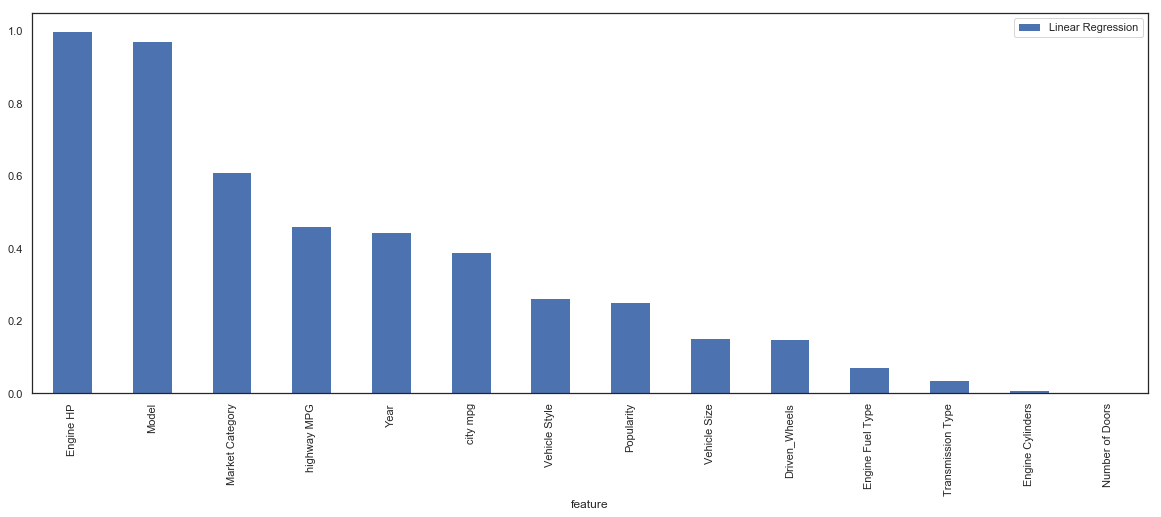

In [67]:
feature_score.sort_values('Linear Regression', ascending=False).plot(kind='bar', figsize=(20, 7))